In [88]:
import math

import matplotlib.pyplot as plt
import numpy as np
import os
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')



ibmqfactory.load_account:WARNING:2024-01-24 18:25:52,070: Credentials are already in use. The existing account in the session will be replaced.


In [112]:
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm

ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n - 1)])
y_lornz = lambda a, x, w: np.pi * (2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
y_lornz_single = lambda a, x, w: (2 * a / ((a ** 2 + x ** 2) * 2 * np.pi))


def sinc(x_values):
    X = []
    for x in x_values:
        X.append((np.sin(2 * x * np.pi) / (2 * x * np.pi) if x != 0 else 1))
    return X


def fisher_inf(x, w, a):
    cos_wx_squared = np.cos(w * x)**2
    sin_wx_squared = np.sin(w * x)**2
    exp_ax = np.exp(a * x)

    term1 = x**2 * cos_wx_squared / (exp_ax + np.cos(w * x))**2
    term2 = x**2 * sin_wx_squared / (exp_ax + np.cos(w * x))**2

    return term1 + term2

def effective_hem(size, J, W):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        #Z.reverse()
        hem[i, i] = h(size, J, Z)
        hem[i, i] += sum([W[k] for k in range(size) if binary[k] == '1'])
    return hem

J =  []
W =  [3]


Creating experiments: 100%|██████████| 50/50 [00:00<00:00, 212.02it/s]


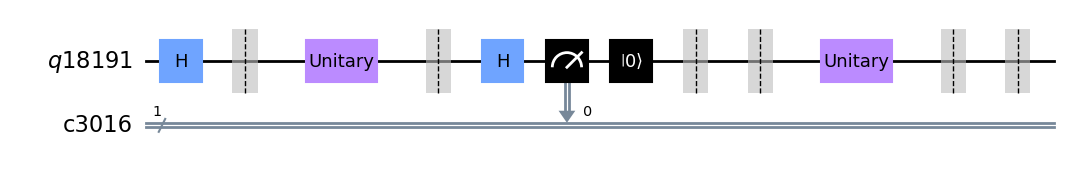

In [136]:
import numpy as np
import math
n = 1
T = np.pi
shots = 100
measurements = 50
delay = np.linspace(0, T, measurements)

W = [random.gauss(3, 1) for _ in range(n)]
L = [random.gauss(1, 1) for _ in range(n)]
J = [random.gauss(3, 1) for _ in range(n - 1)]

L = [1]
#L = [2,3,4]
#
W = [3]
# #W = [3]
# J = [0, 1]
# # W = [3]
# # L = [3]



total_shots = shots * measurements
fisher_values = [fisher_inf(t, W[0], L[0]) for t in delay]
Shots = [math.ceil(total_shots * fisher_values[i] / sum(fisher_values))for i in range(measurements)]
Shots = [Shots[i] if Shots[i] > 0 else 1 for i in range(measurements)]
print("J = ", J)
print("W = ", W)

batch1 = []
batch2 = []

exp = []
delay_fisher = np.linspace(0.2, np.pi/2, measurements)
for t in tqdm(delay, desc='Creating experiments'):
    exp = RamseyExperiment(n, t, shots, J, W, L)
    exp.create_circuit_detuning()
    exp.add_decay_raw()
    #exp.add_noise_raw()
    #exp.add_decay()
    batch1.append(exp)
i = 0
for t in tqdm(delay, desc='Creating experiments'):
    exp = RamseyExperiment(n, t, shots, J, W, L)
    exp.create_circuit_detuning()
    exp.add_decay_raw()
    #exp.add_noise_raw()
    #exp.add_decay()
    batch2.append(exp)
    #print(t)
ramseyBatch1 = RamseyBatch(batch1)
ramseyBatch2 = RamseyBatch(batch2)
batch2[1].circuit.draw(output='mpl')  # 'mpl' for matplotlib drawing

#print(effective_hem(3,J,W))

In [14]:
print(ramseyBatch2.RamseyExperiments[5].get_counts_from_raw())
print(ramseyBatch2.RamseyExperiments[70].W)
print("delay last = ", delay[-1])
print(effective_hem(ramseyBatch1.RamseyExperiments[70].n, ramseyBatch1.RamseyExperiments[70].J,
                    ramseyBatch1.RamseyExperiments[70].W))

{'00100': 13, '01011': 1, '00010': 11, '01010': 4, '01100': 5, '00000': 28, '01000': 13, '00111': 2, '00001': 8, '00110': 2, '00101': 6, '01101': 2, '01001': 4, '01111': 1}


IndexError: list index out of range

W =  3 Decay =  1
Normal times:
fit W =  3.057366914437062
fit decay =  1.0355811696440118
Error precent:  1.9122304812354034
Log likelihood:
{'gamma': 1.100296814531106, 'w0': -2.9472761161571603}
Error precent:  -198.2425372052387


C:\Projects\Crosstalk\Ramsey_ExperimentV2.py:471: RuntimeWarning: invalid value encountered in log
  likelihood += downs * np.log(f(self.delay[j], w, a, -1))
C:\Projects\Crosstalk\Ramsey_ExperimentV2.py:470: RuntimeWarning: invalid value encountered in log
  likelihood += ups * np.log(f(self.delay[j], w, a, 1))


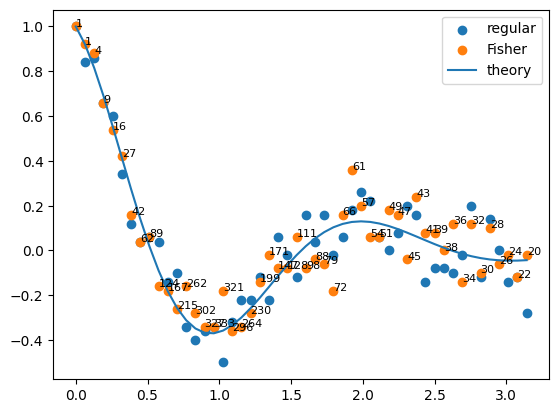

In [137]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy import signal

k = 0

experiments = ramseyBatch1.RamseyExperiments



#lt.xlim([0,3])
correct_z = lambda  t, w, a : (np.cos(w * t)) * np.exp(-a * t)
std_z = lambda t, w, a: np.sqrt(1 - ((np.cos(w * t)) * np.exp(-a * t))**2)/np.sqrt(shots)


#plt.plot(delay, correct_z(delay, W[k], L[k]), label='theory')
#plt.plot(ext_delay, ext_signal, label='signal')
plt.scatter(delay,ramseyBatch1.get_zi(k), label='regular')
plt.scatter(delay,ramseyBatch2.get_zi(k), label='Fisher')
plt.plot(delay, correct_z(delay, W[k], L[k]), label='theory')
#plt.plot(ext_delay, gausian_filtered_signal, label='gaussian filtered')
for i in range(len(delay)):
    plt.text(delay[i], ramseyBatch2.get_zi(k)[i], str(Shots[i]), fontsize=8)

plt.legend()
#plt.plot(delay,y_smooth)

param1 = ramseyBatch1.fit_to_theory()
param2 = ramseyBatch2.log_likelihood_estimator()

print("W = " , W[k], "Decay = ", L[k])
print("Normal times:")
print("fit W = ", param1[k][1])
print("fit decay = ", param1[k][0])
print("Error precent: ", (param1[k][1] - W[k])/W[k] * 100)
print("Log likelihood:")
print(param2[k])
print("Error precent: ", (param2[k]["w0"] - W[k])/W[k] * 100)

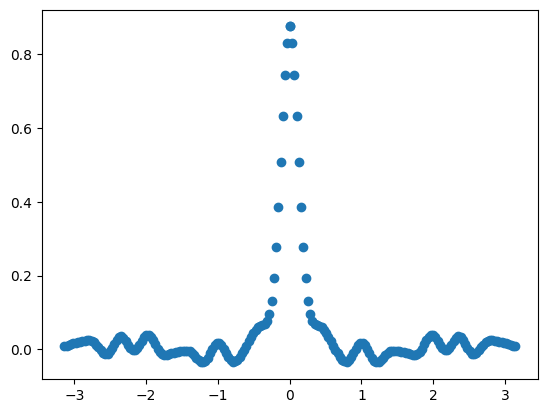

In [152]:
fft_output = np.fft.fft(ext_signal)
sample_rate = len(delay) / delay[-1]
frequencies = np.fft.fftfreq(len(ext_signal), 1 / sample_rate)
# frequencies *= (2 * np.pi)
# paired = sorted(zip(frequencies, fft_output))
# frequencies, fft_output = zip(*paired)
# frequencies = np.array(frequencies)
# fft_output = np.array(fft_output)
for i in range(len(frequencies)):
    if np.abs(frequencies[i]) > 3.09:
        fft_output[i] = 0
reversed_signal = np.fft.ifft(fft_output)
#plt.xlim([0,50])
#plt.ylim([-0.3,2])
plt.scatter(ext_delay, reversed_signal, label='reversed')

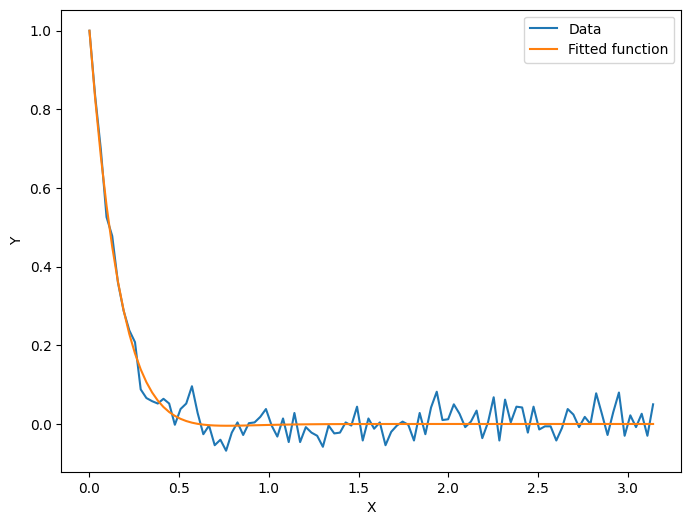

[5.8560855  2.58463159]


In [160]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def model_func(x, a, w):
    """
    Model function: (cos(w*x) - 1)*(exp(-a*x)) + 1
    :param x: Independent variable
    :param a: Parameter a of the model
    :param w: Parameter w of the model
    :return: Computed y values
    """
    return (np.cos(w * x)) * np.exp(-a * x)


def fit_data(x_points, y_points):
    """
    Fit the given data points to the model function and plot the results.
    :param x_points: List or array of x values
    :param y_points: List or array of y values
    :return: Optimized parameters a and w
    """
    # Initial guess for the parameters
    initial_guess = [1,1]

    # Perform the curve fitting
    params, params_covariance = curve_fit(model_func, x_points, y_points, p0=initial_guess)

    # Plotting the data and the fit
    plt.figure(figsize=(8, 6))
    plt.plot(x_points, y_points, label='Data')
    plt.plot(x_points, model_func(x_points, *params), label='Fitted function')

    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.xlim(0,1)
    plt.legend()
    plt.show()

    return params


qubits_measured = ramseyBatch2.qubits_measured

x_data = delay
y_data = ramseyBatch1.get_zi(k)
y_data_filtered = np.delete(reversed_signal[np.where(ext_delay >= 0)], 0)

params = fit_data(x_data, y_data)

# Fit the data
#fit_j = ramseyBatch1.fit_to_theory()[k][1]
#fit_w = ramseyBatch1.fit_to_theory()[qubits_measured[k]][1]
print(params)
#print("fit W = ", fit_w)
#print("J = ", fit_j - fit_w)

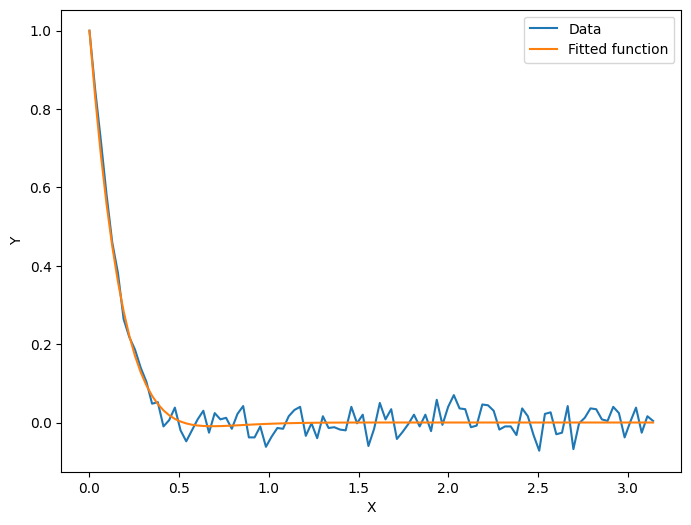

[3.00520748]


In [98]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def fit_data2(x_points, y_points, a):
    """
    Fit the given data points to the model function and plot the results.
    :param x_points: List or array of x values
    :param y_points: List or array of y values
    :return: Optimized parameters a and w
    """

    def model_func(x, w):

        """
        Model function: (cos(w*x) - 1)*(exp(-a*x)) + 1
        :param x: Independent variable
        :param a: Parameter a of the model
        :param w: Parameter w of the model
        :return: Computed y values
        """
        return (np.cos(w * x)) * np.exp(-a * x)

    # Initial guess for the parameters
    initial_guess = 1

    # Perform the curve fitting
    params, params_covariance = curve_fit(model_func, x_points, y_points, p0=initial_guess)

    # Plotting the data and the fit
    plt.figure(figsize=(8, 6))
    plt.plot(x_points, y_points, label='Data')
    plt.plot(x_points, model_func(x_points, *params), label='Fitted function')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

    return params


x_data = delay
y_data = ramseyBatch1.get_zi(k)
y_data_filtered = np.delete(reversed_signal[np.where(ext_delay >= 0)], 0)

params = fit_data2(x_data, y_data, 5.7)

# Fit the data
#fit_j = ramseyBatch1.fit_to_theory()[k][1]
#fit_w = ramseyBatch1.fit_to_theory()[qubits_measured[k]][1]
print(params)
#print("fit W = ", fit_w)
#print("J = ", fit_j - fit_w)

C:\Users\user\AppData\Local\Temp\ipykernel_3008\705946493.py:8: RuntimeWarning: invalid value encountered in sqrt
  -np.sqrt(
C:\Users\user\AppData\Local\Temp\ipykernel_3008\705946493.py:10: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(


{'gamma': 3.1915171311831574, 'w0': 3.615672337871141}
found J =  0.6156723378711408


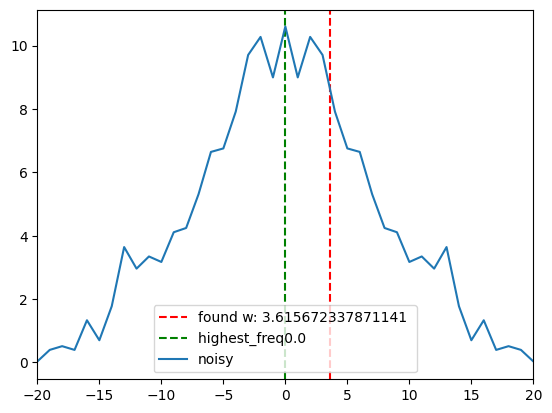

In [159]:
#%matplotlib notebook
k = 2
a = L[k]
frequencies, amplitudes = ramseyBatch1.fft(filter=False)
amplitudes = amplitudes[k]
highest_freq = np.abs(frequencies[np.argmax(amplitudes)])
w_solutions = [
    -np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    -np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 + 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    np.sqrt(-(a ** 2) / 3 + (highest_freq ** 2) / 3 + 2 * np.sqrt(
        a ** 4 + (a ** 2) * highest_freq ** 2 + highest_freq ** 4) / 3)
]

#plt.plot(frequencies_ext_sorted, Y1, label='lorenzian',color='red')
#plt.plot(frequencies_ext_sorted, Y2)
#plt.plot(frequencies_ext_sorted, np.abs(Y), label='theory',color='red')

parameters = ramseyBatch1.cauchy_log_likelihood(k)
print(parameters)
print("found J = ", parameters['w0'] - W[k])
#print("J = ", J[k])
plt.axvline(x=parameters['w0'], color='red', linestyle='--', label=f'found w: {parameters["w0"]} ')
plt.axvline(x=highest_freq, color='green', linestyle='--', label=f'highest_freq{highest_freq} ')
plt.plot(frequencies, amplitudes, label='noisy')
plt.xlim([-20, 20])
#plt.yscale('log')
plt.legend()
plt.show()

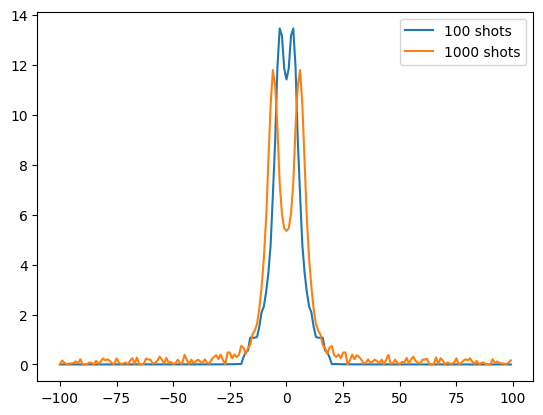

In [34]:
k = 3
a = L[k]
ramseyBatch1.fft()
frequencies = ramseyBatch1.frequencies
amplitudes1 = ramseyBatch1.fft_data[k]
#frequencies, amplitudes= ramseyBatch2.fft()

ramseyBatch2.fft()
amplitudes2 = ramseyBatch2.fft_data[k]
plt.plot(frequencies, amplitudes1, label='100 shots')
plt.plot(frequencies, amplitudes2, label='1000 shots')

#plt.xlim([-50,50])
plt.legend()
plt.show()

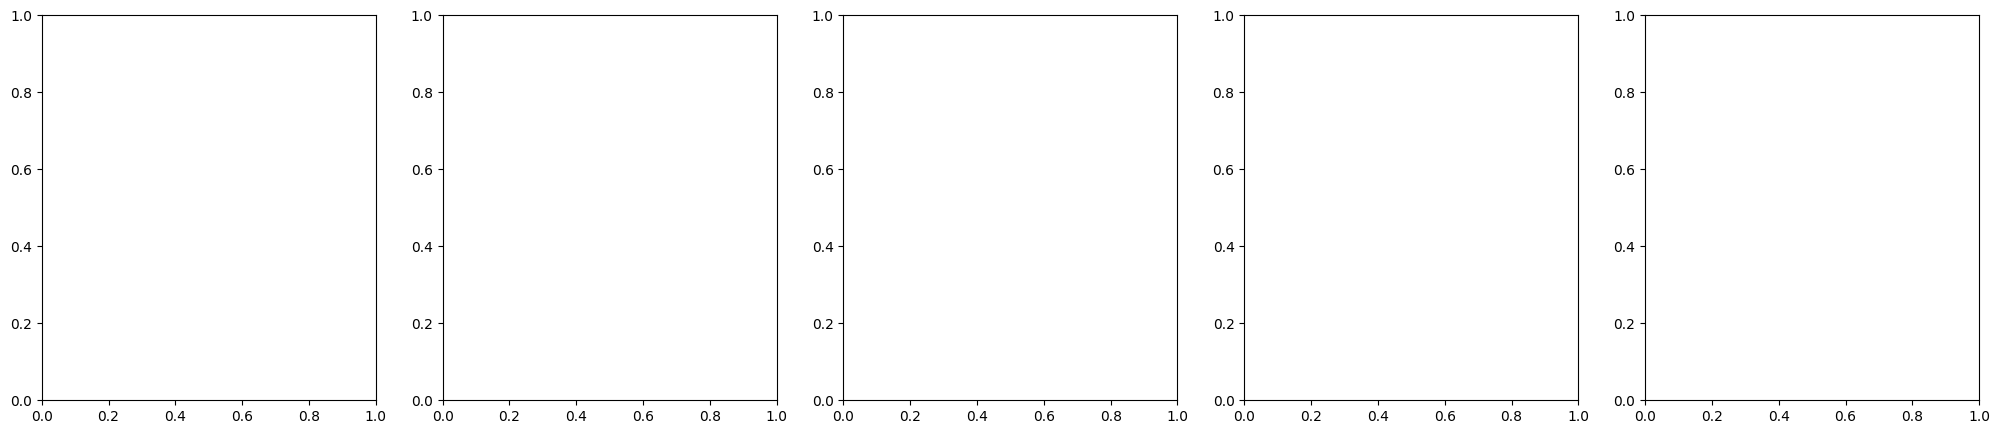

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Set the range for k

# Create subplots
fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))  # Adjust figsize as needed

# Iterate over each k


In [9]:
from sympy import symbols, integrate, oo, pi, Abs

a, x, w = symbols('a x w')
f = x * pi * (2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
mu = integrate(f, (x, 0, oo))
mu.simplify
print(mu)

-(pi*a - I*pi*w)*log((-pi*a**2 + 2*a*(pi*a - I*pi*w) - pi*w**2)/pi) - (pi*a + I*pi*w)*log((-pi*a**2 + 2*a*(pi*a + I*pi*w) - pi*w**2)/pi) + oo*sign(a)


In [10]:
from sympy import symbols, diff, solve

a, x, w = symbols('a x w')

y_lornz_single = lambda a, x: (a / ((a ** 2 + x ** 2) * np.pi))
X = np.linspace(-100, 100, 1000)
Y1 = y_lornz_single(3, X)


def m_l_fun(a, y):
    s = 0
    for i in range(len(y)):
        s += (y[i] ** 2 - a ** 2) / (y[i] ** 2 + a ** 2)
    return s


m_l = m_l_fun(a, Y1)

solution = solve(m_l, a)
print(solution)

# print(np.sum(Y1))
# sum = np.sum(Y1)





KeyboardInterrupt



In [490]:
from scipy.optimize import minimize

k = 3
fft_data = gaussian_filter(ramseyBatch1.fft_data[k], sigma=0)
probs = fft_data / np.sum(fft_data)
samples = np.random.choice(ramseyBatch1.frequencies, size=10000, p=probs)


def cauchy_log_likelihood(data):
    def neg_log_likelihood(params):
        gamma, w = np.abs(params[0]), params[1]  # Ensure gamma is positive
        gamma = np.abs(gamma)  # Ensure gamma is positive
        log_likelihood = np.sum(0.001 * np.log(
            np.pi * (2 * gamma / (gamma ** 2 + (data - w) ** 2) + 2 * gamma / (gamma ** 2 + (data + w) ** 2))))
        return -log_likelihood  # Negative because we minimize

    # Initial guess for gamma using median absolute deviation
    initial_params = [5, 5]

    # Optimize using a different method (e.g., 'Nelder-Mead')
    result = minimize(neg_log_likelihood, initial_params, method='Powell')
    gammas = np.linspace(0, 10, 100)
    #plt.plot(gammas, [neg_log_likelihood(gamma) for gamma in gammas])
    if result.success:
        return result.x  # The optimal gamma value
    else:
        raise ValueError("Optimization did not converge: " + result.message)


# Example usage
data = samples
gamma, w0 = cauchy_log_likelihood(data)
print("Estimated gamma:", gamma)
print("Estimated w:", w0)

Estimated gamma: 3.28398967012999
Estimated w: 3.750467187494088


In [ ]:
plt.plot(frequencies, ramseyBatch2.fft_data[1])
plt.xlim([-20, 20])
plt.legend()
plt.show()

In [ ]:
L = [0, 2, 4, 6, 8]
